In [1]:
%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
from msmbuilder.decomposition import tICA, PCA

In [3]:
dataFull = np.loadtxt('ala4_explicit/COLVAR_md_explicit_10ns')

In [4]:
data = dataFull[:,1:7]
sumabs=dataFull[:,-1]


In [5]:
print(data)
print(sumabs)

[[-2.401463  2.721934 -1.359381  2.476104 -1.271216  2.361919]
 [-2.341986  2.873031 -1.109471  2.587082 -1.49281  -3.125739]
 [-2.458682  2.601563 -1.365601  2.60777  -1.5563    3.084817]
 ...
 [-1.381258  2.279866 -2.30461   3.077384 -1.124621  2.815719]
 [-1.695112  1.912944 -1.793466  2.932431 -1.201032  2.709006]
 [-1.37564   1.898676 -1.830701  2.715888 -0.99448   2.054822]]
[0.758897 0.759956 0.749528 ... 0.463711 0.542259 0.610034]


In [6]:
sincos=[]

for i in range(0,len(data)):
    temp=[]
    for j in range(0,6):
        temp.append(np.sin(data[i,j]))
        temp.append(np.cos(data[i,j]))
    sincos.append(temp)

diheds_sincos=np.array(sincos)

In [7]:
fe = np.loadtxt('ala4_explicit/fe')
print(fe)

[1.397509  1.983793  1.776999  ... 1.375204  0.9172205 1.062112 ]


In [8]:
X = sumabs
X_dihed = diheds_sincos
y = fe

xnew_sincos=[]
xnew=[]
ynew=[]
for i in range(0,len(X)):
    t1=[]
    t1.append(X[i])
    xnew.append(t1)
    t2=[]
    #t2.append(y[i])
    #ynew.append(t2)
    t3=[]
    for j in range(0,12):
        t3.append(X_dihed[i][j])
    xnew_sincos.append(t3)

xnew=np.array(xnew)
#ynew=np.array(ynew)
xnew_sincos=np.array(xnew_sincos)

print(xnew_sincos[0])
sum(xnew_sincos[:,0])

[-0.67438365 -0.73838113  0.40744875 -0.91322807 -0.9777349   0.20984392
  0.61744359 -0.78661516 -0.95546043  0.29511925  0.70304738 -0.71114301]


-41869.03006544425

In [9]:
x_sincos_centered=xnew_sincos

for i in range(0,len(xnew_sincos[0])):
    avg=sum(xnew_sincos[:,i])/len(xnew_sincos)
    print(avg)
    x_sincos_centered[:,i]=x_sincos_centered[:,i]-avg
    
print(x_sincos_centered[0])

-0.8373638540318044
-0.11089574722092439
0.3988736246362931
-0.6151028330760221
-0.8623292715556716
-0.05009631871410182
0.22080465483150075
-0.28863031532459527
-0.8339834437230369
-0.1470649727591676
0.33971750888719676
-0.49980440773681223
[ 0.1629802  -0.62748538  0.00857513 -0.29812524 -0.11540562  0.25994024
  0.39663893 -0.49798485 -0.12147698  0.44218422  0.36332987 -0.21133861]


In [10]:
import sklearn
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sincos_centered, sumabs, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape,y_test.shape )

(40000, 12) (40000,) (10001,)


In [11]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
from keras.layers import Lambda, Input, Dense, Concatenate
from keras.models import Model
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

2.1.0


Using TensorFlow backend.


In [12]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [13]:
def circular(args):
    
    z_circular = args
    #print(z_circular)
    #print(K.sum(K.square(z_circular),axis=-1,keepdims=True))
    return z_circular/K.sqrt(K.sum(K.square(z_circular),axis=-1,keepdims=True))
    
    

In [14]:
def new_sampling(args):
    
    z_circular, z_log_var = args
    
    

In [22]:
original_dim=12
inputs = Input(shape=(original_dim,),name='encoder_input')
latent_dim = 2
batch_size=100
epochs=500

    
x = Dense(8)(inputs)
x = Dense(4, activation='tanh')(x)
 
z_mean = Dense(latent_dim,activation='tanh',name='z_mean')(x)
#z_log_var = Dense(latent_dim,activation='tanh', name='z_log_var')(x)

#z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z_circular = Lambda(circular, output_shape=(latent_dim,), name='z_circular')(z_mean)
#z = Lambda(new_sampling, output_shape=(latent_dim,), name='z')([z_circular, z_log_var])

# instantiate encoder model
#encoder = Model(inputs, [z_mean, z_log_var, z_circular], name='encoder')
encoder = Model(inputs,  z_circular, name='encoder')

encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
    
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(4, activation='tanh')(latent_inputs)
x = Dense(8, activation='tanh')(x)
outputs = Dense(original_dim)(x)


#out1= Dense(2)(x)
#out2= Dense(2)(x)
#out3= Dense(2)(x)
#out4= Dense(2)(x)
#out5= Dense(2)(x)
#out6= Dense(2)(x)

#o1=Lambda(circular, output_shape=(2,), name='z_1')(out1)
#o2=Lambda(circular, output_shape=(2,), name='z_2')(out2)
#o3=Lambda(circular, output_shape=(2,), name='z_3')(out3)
#o4=Lambda(circular, output_shape=(2,), name='z_4')(out4)
#o5=Lambda(circular, output_shape=(2,), name='z_5')(out5)
#o6=Lambda(circular, output_shape=(2,), name='z_6')(out6)

#outputs = Concatenate()([o1,o2,o3,o4,o5,o6])

#outputs= Dense(12)(o7)

print(outputs)    
    
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 36        
_________________________________________________________________
z_mean (Dense)               (None, 2)                 10        
_________________________________________________________________
z_circular (Lambda)          (None, 2)                 0         
Total params: 150
Trainable params: 150
Non-trainable params: 0
_________________________________________________________________
Tensor("dense_15/BiasAdd:0", shape=(None, 12), dtype=float32)
Model: "decoder"
________________________________________________

In [23]:

#models = (encoder, decoder)
#data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

#kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
#kl_loss = K.sum(kl_loss, axis=-1)
#kl_loss *= -0.5

#error_loss = K.square(K.sum(K.square(outputs),axis=-1)-6)
#error_loss *= 0.5

#vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(reconstruction_loss)

vae.compile(optimizer='rmsprop')
vae.summary()





Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12)                0         
_________________________________________________________________
encoder (Model)              (None, 2)                 150       
_________________________________________________________________
decoder (Model)              (None, 12)                160       
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


In [24]:
kl_loss.shape

NameError: name 'kl_loss' is not defined

In [25]:
autoencoder_train=vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_explicit_newloss.h5')

Train on 40000 samples, validate on 10001 samples
Epoch 1/500
40000/40000 [==============================] - 1s 28us/step - loss: 1.9723 - val_loss: 1.4735
Epoch 2/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.4388 - val_loss: 1.4260
Epoch 3/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.3511 - val_loss: 1.3062
Epoch 4/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.2596 - val_loss: 1.2389
Epoch 5/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.2011 - val_loss: 1.1876
Epoch 6/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.1572 - val_loss: 1.1518
Epoch 7/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.1240 - val_loss: 1.1156
Epoch 8/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.0853 - val_loss: 1.0765
Epoch 9/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.0572 - val_loss: 1.0

40000/40000 [==============================] - 1s 13us/step - loss: 0.8797 - val_loss: 0.8908
Epoch 78/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8775 - val_loss: 0.8908
Epoch 79/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8762 - val_loss: 0.8905
Epoch 80/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8760 - val_loss: 0.8918
Epoch 81/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8740 - val_loss: 0.8872
Epoch 82/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8723 - val_loss: 0.8825
Epoch 83/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8724 - val_loss: 0.8819
Epoch 84/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8710 - val_loss: 0.8842
Epoch 85/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8707 - val_loss: 0.8859
Epoch 86/500
40000/40000 [========================

40000/40000 [==============================] - 1s 15us/step - loss: 0.8460 - val_loss: 0.8570
Epoch 153/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8454 - val_loss: 0.8565
Epoch 154/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8450 - val_loss: 0.8566
Epoch 155/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8448 - val_loss: 0.8578
Epoch 156/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8449 - val_loss: 0.8559
Epoch 157/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8451 - val_loss: 0.8557
Epoch 158/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8447 - val_loss: 0.8564
Epoch 159/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8441 - val_loss: 0.8572
Epoch 160/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8443 - val_loss: 0.8575
Epoch 161/500
40000/40000 [===============

Epoch 228/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8378 - val_loss: 0.8547
Epoch 229/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8379 - val_loss: 0.8489
Epoch 230/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8374 - val_loss: 0.8516
Epoch 231/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8377 - val_loss: 0.8515
Epoch 232/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8373 - val_loss: 0.8487
Epoch 233/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8377 - val_loss: 0.8520
Epoch 234/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8376 - val_loss: 0.8499
Epoch 235/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8380 - val_loss: 0.8511
Epoch 236/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8380 - val_loss: 0.8506
Epoch 237/500
40000/40000 [=

40000/40000 [==============================] - 1s 13us/step - loss: 0.8348 - val_loss: 0.8453
Epoch 304/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8355 - val_loss: 0.8469
Epoch 305/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8349 - val_loss: 0.8466
Epoch 306/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8339 - val_loss: 0.8456
Epoch 307/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8337 - val_loss: 0.8471
Epoch 308/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8346 - val_loss: 0.8447
Epoch 309/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8352 - val_loss: 0.8461
Epoch 310/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8347 - val_loss: 0.8479
Epoch 311/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8350 - val_loss: 0.8459
Epoch 312/500
40000/40000 [===============

Epoch 379/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8341 - val_loss: 0.8450
Epoch 380/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8323 - val_loss: 0.8453
Epoch 381/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8328 - val_loss: 0.8444
Epoch 382/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8329 - val_loss: 0.8458
Epoch 383/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8328 - val_loss: 0.8450
Epoch 384/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8326 - val_loss: 0.8448
Epoch 385/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8332 - val_loss: 0.8447
Epoch 386/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8322 - val_loss: 0.8443
Epoch 387/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8328 - val_loss: 0.8470
Epoch 388/500
40000/40000 [=

40000/40000 [==============================] - 1s 13us/step - loss: 0.8308 - val_loss: 0.8436
Epoch 455/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8314 - val_loss: 0.8462
Epoch 456/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8306 - val_loss: 0.8422
Epoch 457/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8321 - val_loss: 0.8462
Epoch 458/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8314 - val_loss: 0.8436
Epoch 459/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8301 - val_loss: 0.8456
Epoch 460/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8309 - val_loss: 0.8530
Epoch 461/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8314 - val_loss: 0.8443
Epoch 462/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8312 - val_loss: 0.8445
Epoch 463/500
40000/40000 [===============

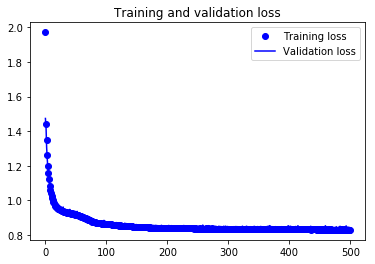

In [26]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'bo', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

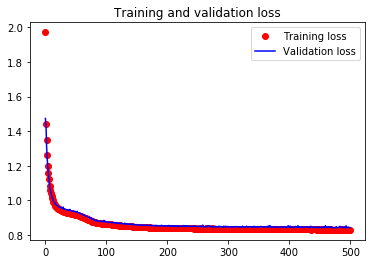

In [27]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
pred_test = vae.predict(x_test)
pred_train = vae.predict(x_train)

In [29]:
pred.shape

NameError: name 'pred' is not defined

In [30]:
z_test = encoder.predict(x_test, batch_size=batch_size)

In [31]:
z_test

array([[-0.99625397, -0.08647508],
       [ 0.17145225,  0.9851924 ],
       [-0.7564072 ,  0.6541012 ],
       ...,
       [-0.96381056,  0.26658824],
       [ 0.8915978 , -0.45282817],
       [ 0.79465693,  0.60705876]], dtype=float32)

In [34]:
decoder_test=decoder.predict(z_test,batch_size=batch_size)

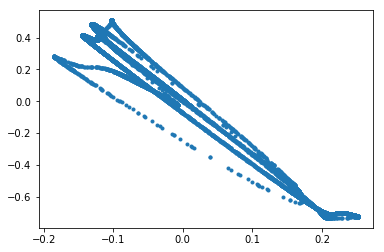

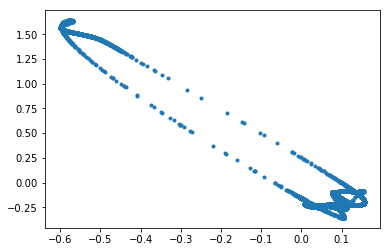

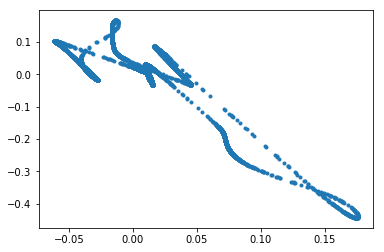

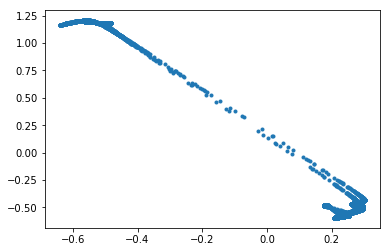

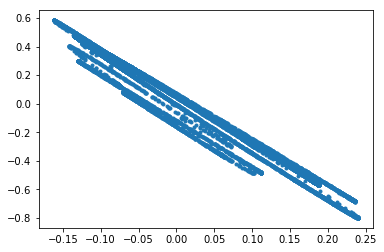

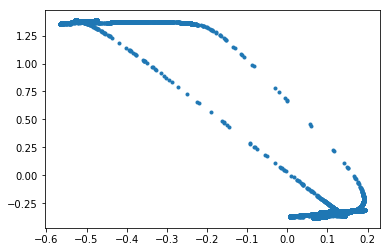

In [35]:
for i in range(6):
    plot(decoder_test[:,i*2],decoder_test[:,i*2+1],'.')
    show()

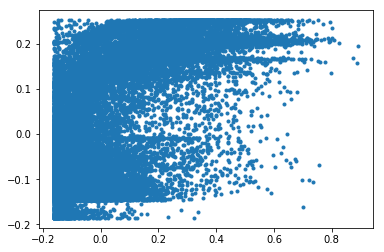

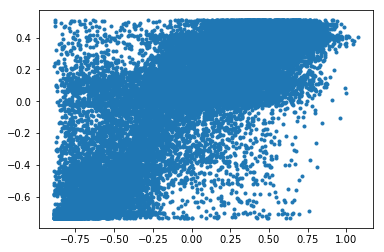

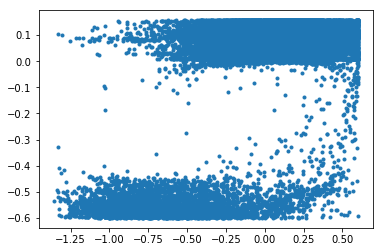

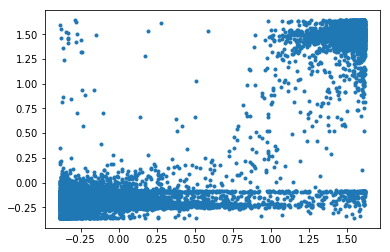

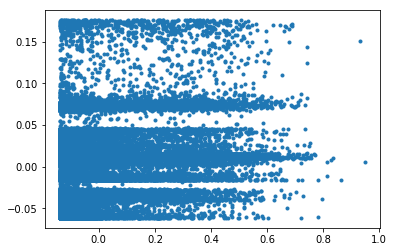

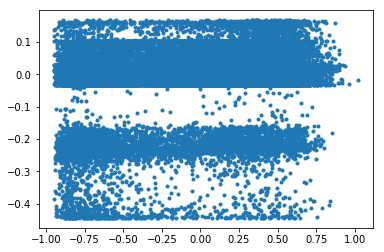

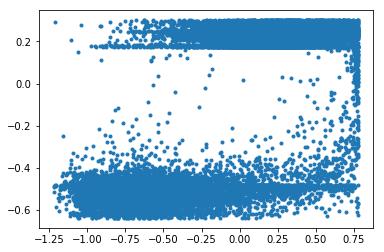

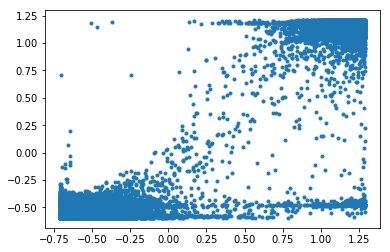

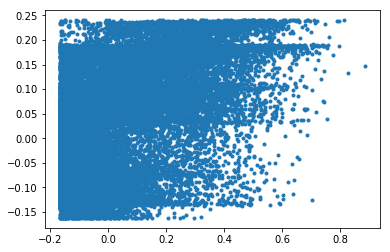

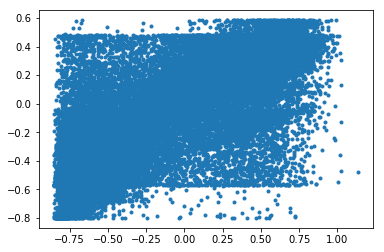

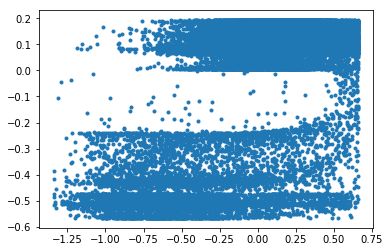

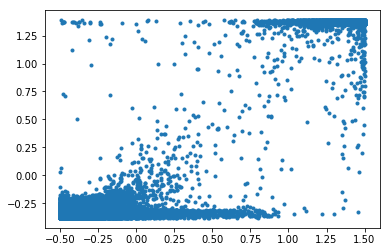

In [36]:
for i in range(original_dim):
    plot(x_train[:,i],pred_train[:,i],'.')
    show()

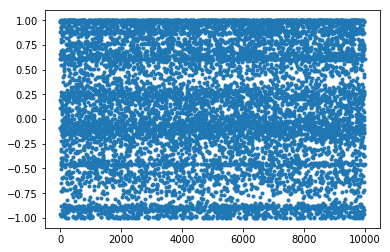

In [40]:
#plot(z_test[0][:,0],'.')
plot(z_test[:,1],'.')

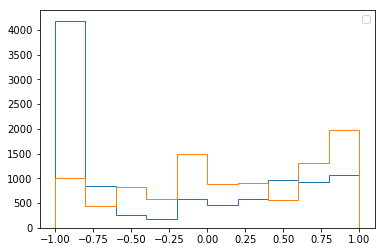

In [41]:
hist(z_test[:,0], histtype='step', )
hist(z_test[:,1], histtype='step')
legend()

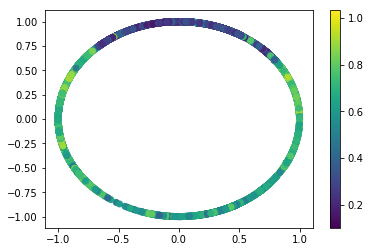

In [42]:

scatter(z_test[:,0],z_test[:,1],c=y_test)
colorbar()

In [43]:
z_train = encoder.predict(x_train, batch_size=batch_size)
z_final = encoder.predict(x_sincos_centered, batch_size=batch_size)

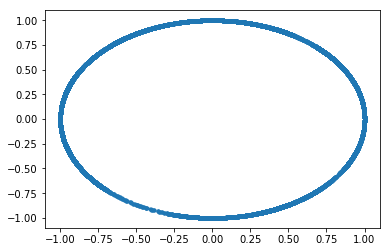

In [45]:
plot(z_train[:,0],z_train[:,1],'.')


In [46]:
weights = vae.get_weights()

In [47]:
for i in range(14): print(weights[i].shape)

(12, 8)
(8,)
(8, 4)
(4,)
(4, 2)
(2,)
(2, 4)
(4,)
(4, 8)
(8,)
(8, 12)
(12,)


IndexError: list index out of range

In [ ]:
print(weights[0])

In [ ]:
first_layer_weights = weights[0]
first_layer_biases  = weights[1]
second_layer_weights = weights[2]
second_layer_biases  = weights[3]
third_layer_weights = weights[4]
third_layer_biases  = weights[5]

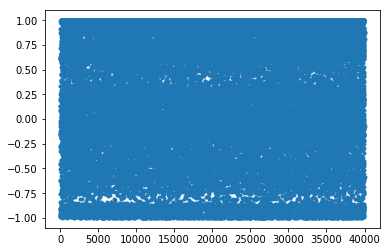

In [48]:
plot(z_train[:,1],'.')

In [49]:
np.savetxt('temp',weights[5].T,delimiter=',')

In [50]:
weights[1]

array([-0.45293006,  0.06888013,  0.49570498, -0.02761213, -0.7170076 ,
       -0.9685262 ,  0.14283527,  0.23072767], dtype=float32)

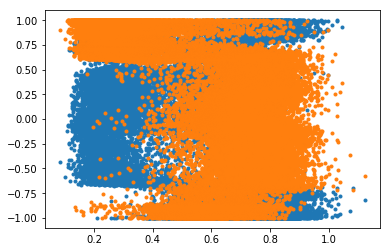

In [52]:
plot(y_train, z_train,'.')

In [ ]:
scatter(x_train[:,11],reshape(z_train[0],(40000,)))